# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

In [70]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    Args:
      img: Color image on to draw lines.
      lines: Lines from Hough transform.
      color: Color of superimposed lines.
      thickness: Thickness of lines (in pixels?).
    
    Returns:
      TBD
    
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    
    """
    line_image = np.copy(img)*0 # Blank image on which to draw lines. 
    shape_img = img.shape
    x_max = shape_img[1]
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image, (x1, y1), (x2, y2), color, thickness)
    return line_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns 
      line_img: Image with hough lines drawn.
      lines: Hough lines from the transform of form x1,y1,x2,y2.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines
                
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    Args:
      img: Output of the hough_lines(), An image with lines drawn on it.
           Should be a blank image (all black) with lines drawn on it.
      initial_img: image before any processing.
      α: TBD
      β: TBD
      λ: TBD
      
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def lane_mark_image(initial_image):
    """ Process initial image to include long lane markers, each composed of a single line.
    Args:
      initial_image: 3D numpy array
      
    Returns:
      final_image: 3D numpy array with lanes marked
    
    """
    # Grayscale the image.
    gray_image = grayscale(initial_image)

    # Gaussian blur the image
    kernel_size = 5
    blur_gray = gaussian_blur(gray_image, kernel_size)

    # Canny edge detection
    low_threshold = 50
    high_threshold = 150
    canny_blur_gray = canny(blur_gray, low_threshold, high_threshold)

    # Define four-sided polygon to mask image
    imshape = initial_image.shape
    vert1 = (130,imshape[0]) # bottom left
    vert2 = (440, 330) # top left
    vert3 = (525,330) # top right
    vert4 = (950, imshape[0]) # bottom right
    vertices = np.array([[vert1, vert2, vert3, vert4]], dtype=np.int32)
    masked_canny_blur_gray = region_of_interest(canny_blur_gray, vertices)
    
    # Hough transform to get all lines in the ROI
    rho = 3 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 10    # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 20 #minimum number of pixels making up a line
    max_line_gap = 50 # maximum gap in pixels between connectable line segments
    line_image = np.copy(initial_image)*0 # creating a blank to draw lines on
    lines = hough_lines(masked_canny_blur_gray, rho, 
                                           theta, threshold, min_line_len, max_line_gap) 
    
    # Set boundary values for drawing lines on final image
    y_min = 350 #y1, upper portion (apex of trapezoid)
    y_max = imshape[0] #y2, lower portion (lower frame boundary)    
    x_max = imshape[1]-1
    
    out_lines = compute_long_line(lines, y_min, y_max, x_max)
    
    # Get dark image with red lines drawn on lane markers
    line_image = draw_lines(initial_image, out_lines, color=[255, 0, 0], thickness=10)
    
    # Superimpose red lane markers on original image
    final_img = weighted_img(line_image, initial_image, α=0.8, β=1., λ=0.)
    
    return final_img

def compute_long_line(lines, y_min, y_max, x_max):
    """Compute single line for left, right lanes
    Args:
      lines: Hough lines from the transform of form x1,y1,x2,y2.
      y_min: self explanatory
      y_max: self explanatory
      x_max: self explanatory

    Returns:
      lines_updated: ND array with longest line
    """
    neg_slope_longest_line = [0,0,0] # [m, b, line_length]
    pos_slope_longest_line = [0,0,0] # [m, b, line_length]
    neg_m_accumulator = 0
    neg_b_accumulator = 0
    neg_line_len_accumulator = 0
    pos_m_accumulator = 0
    pos_b_accumulator = 0
    pos_line_len_accumulator = 0    
    
    for curr_line in lines:
        x1 = curr_line[0][0]
        y1 = curr_line[0][1]
        x2 = curr_line[0][2]
        y2 = curr_line[0][3]
        m = (y2-y1)/(x2-x1)
        b = y1 - m * x1
        triang_length = x2 - x1
        triang_height = y2 - y1
        line_len = math.sqrt(triang_length*triang_length + triang_height*triang_height)
        if m < 0: #negative slope
            neg_m_accumulator += m * line_len # weighted accumulator
            neg_b_accumulator += b * line_len # weighted accumulator
            neg_line_len_accumulator += line_len
        else: #positive slope
            pos_m_accumulator += m * line_len # weighted accumulator
            pos_b_accumulator += b * line_len # weighted accumulator
            pos_line_len_accumulator += line_len
    neg_m = neg_m_accumulator / neg_line_len_accumulator
    neg_b = neg_b_accumulator / neg_line_len_accumulator        
    pos_m = pos_m_accumulator / pos_line_len_accumulator
    pos_b = pos_b_accumulator / pos_line_len_accumulator
    
    # Define x vals for these y vals
    x1_negslope = (y_min - neg_b) / neg_m
    x2_negslope = (y_max - neg_b) / neg_m
    x1_posslope = (y_min - pos_b) / pos_m
    x2_posslope = (y_max - pos_b) / pos_m

    if x1_negslope >= x_max:
        x1_negslope = x_max
    if x1_negslope < 0:
        x1_negslope = 0
    if math.isnan(x1_negslope):
        x1_negslope = 0
        
        
    if x2_negslope >= x_max:
        x2_negslope = x_max
    if x2_negslope < 0:
        x2_negslope = 0    
    if math.isnan(x2_negslope):
        x2_negslope = 0

        
    if x1_posslope >= x_max:
        x1_posslope = x_max
    if x1_posslope < 0:
        x1_posslope = 0
    if math.isnan(x1_posslope):
        x1_posslope = 0
        
    if x2_posslope >= x_max:
        x2_posslope = x_max
    if x2_posslope < 0:
        x2_posslope = 0
    if math.isnan(x2_posslope):
        x2_posslope = 0        
        
    x1_negslope = int(round(x1_negslope))
    x2_negslope = int(round(x2_negslope))
    x1_posslope = int(round(x1_posslope))
    x2_posslope = int(round(x2_posslope))
    neg_line = [x1_negslope, y_min, x2_negslope, y_max]
    pos_line = [x1_posslope, y_min, x2_posslope, y_max]
    out_lines = np.zeros((2, 1, 4), dtype=np.uint32)
    neg_line = np.array([neg_line[0], neg_line[1], neg_line[2], neg_line[3]])
    pos_line = np.array([pos_line[0], pos_line[1], pos_line[2], pos_line[3]])
    out_lines[0,0,:] = neg_line
    out_lines[1,0,:] = pos_line

    return out_lines
    


## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

['solidWhiteCurve.jpg', 'solidWhiteRight.jpg', 'solidYellowCurve.jpg', 'solidYellowCurve2.jpg', 'solidYellowLeft.jpg', 'whiteCarLaneSwitch.jpg']
Initial image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Final image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Initial image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Final image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Initial image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Final image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Initial image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Final image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Initial image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Final image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Initial image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Final image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


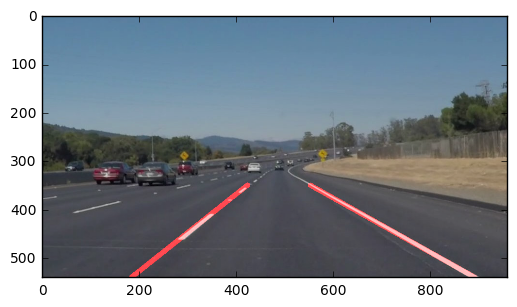

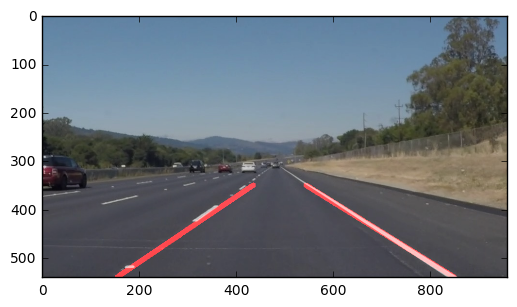

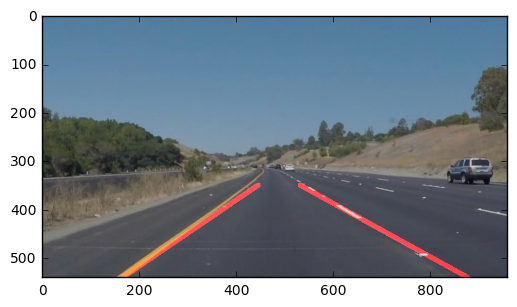

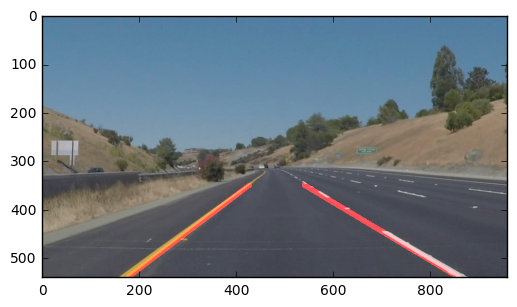

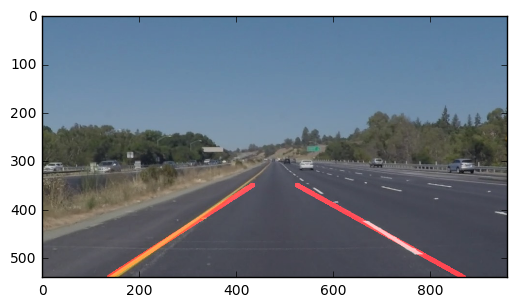

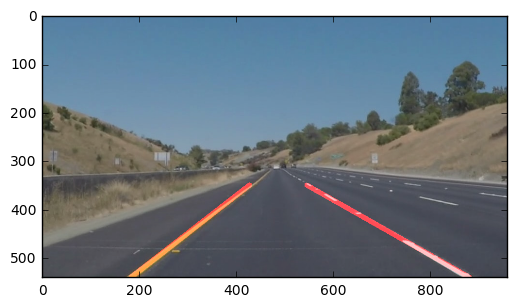

In [71]:
import os
files = os.listdir("test_images/")
print(files)

for file in files:
    filepath = "test_images/" + file
    initial_image = mpimg.imread(filepath)
    final_image = lane_mark_image(initial_image)
    print('Initial image is:', type(initial_image), 'with dimesions:', initial_image.shape)
    print('Final image is:', type(final_image), 'with dimesions:', final_image.shape)
    plt.figure()    
    plt.imshow(final_image)
    
    


run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [66]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [67]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
    result = lane_mark_image(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [68]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4








  0%|          | 0/222 [00:00<?, ?it/s]





  2%|▏         | 4/222 [00:00<00:06, 32.64it/s]





  4%|▎         | 8/222 [00:00<00:06, 33.56it/s]





  5%|▌         | 12/222 [00:00<00:06, 34.73it/s]





  7%|▋         | 16/222 [00:00<00:05, 35.11it/s]





  9%|▉         | 21/222 [00:00<00:05, 36.78it/s]





 11%|█▏        | 25/222 [00:00<00:05, 37.15it/s]





 13%|█▎        | 29/222 [00:00<00:05, 37.60it/s]





 15%|█▍        | 33/222 [00:00<00:05, 37.60it/s]





 17%|█▋        | 37/222 [00:00<00:04, 37.49it/s]





 18%|█▊        | 41/222 [00:01<00:04, 37.36it/s]





 20%|██        | 45/222 [00:01<00:05, 33.81it/s]





 22%|██▏       | 49/222 [00:01<00:05, 30.21it/s]





 24%|██▍       | 53/222 [00:01<00:06, 27.23it/s]





 25%|██▌       | 56/222 [00:01<00:06, 25.53it/s]





 27%|██▋       | 59/222 [00:01<00:08, 20.31it/s]





 28%|██▊       | 62/222 [00:02<00:08, 18.07it/s]





 29%|██▉       | 65/222 [00:02<00:08, 17.97it/s]





 30%|███       | 67/222 [00:02<00

[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 6.55 s, sys: 2.64 s, total: 9.18 s
Wall time: 9.61 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [65]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [72]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4









  0%|          | 0/682 [00:00<?, ?it/s]






  1%|          | 4/682 [00:00<00:19, 34.04it/s]






  1%|          | 8/682 [00:00<00:19, 34.77it/s]






  2%|▏         | 13/682 [00:00<00:18, 36.93it/s]






  2%|▏         | 17/682 [00:00<00:17, 37.24it/s]






  3%|▎         | 22/682 [00:00<00:17, 38.38it/s]






  4%|▍         | 27/682 [00:00<00:16, 39.37it/s]






  5%|▍         | 31/682 [00:00<00:16, 39.24it/s]






  5%|▌         | 35/682 [00:00<00:16, 39.12it/s]






  6%|▌         | 39/682 [00:01<00:16, 38.48it/s]






  6%|▋         | 43/682 [00:01<00:16, 38.02it/s]






  7%|▋         | 47/682 [00:01<00:18, 34.80it/s]






  7%|▋         | 51/682 [00:01<00:20, 31.26it/s]






  8%|▊         | 55/682 [00:01<00:27, 22.42it/s]






  9%|▊         | 58/682 [00:01<00:29, 21.20it/s]






  9%|▉         | 61/682 [00:02<00:31, 19.87it/s]






  9%|▉         | 64/682 [00:02<00:31, 19.56it/s]






 10%|▉         | 67/682 [00:02<00:31, 19.40it/s]






 10%|█        

[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 24 s, sys: 6.46 s, total: 30.5 s
Wall time: 38.2 s


In [73]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections (BCJ)

### Overview of my method
The pipeline is housed within 'lane_mark_image' and returns the image with lanes marked in red. This function accepts a 3D numpy array and processes it by:
  1. Converting to grayscale
  2. Gaussian blur grayscale image
  3. Canny edge detection on gaussian blurred image
  4. Define a 4-sided polygon mask and apply to Canny edge-detected image
  5. Hough transform on masked image to get all eligible lines
  6. Set boundary conditions for minimum, maximum x, y values in marked image
  7. Generate long, single line to annotate final image with 'compute_long_line'. Details below.
  8. Generate dark image with red lanes marked
  9. Superimpose red line image with original image and return.

The trickiest part of the pipeline is 'compute_long_lines', which generates a single long line for each lane. This is done by examining each of the lines returned by the Hough transform. The function proceeds in parts. First, slope (m) and y-intercept (b) is computed for each line. Second, the line is determined to be either positive (left lane) or negative (right lane) and evaluated against similarly-signed slopes. Third, an accumulator for 'm' and 'b' adds the new value of line length multiplied by 'm' and 'b' respectively. A separate accumulator adds all line lengths for a given sign. Fourth, the average 'm' and 'b' for positive and negative slopes are calculated by dividing accumulators by total line lengths. Fifth, the (x1, y1, x2, y2) values for each lane are calculated based on known boundary conditions and the average 'm' and 'b'. Sixth, the single left lane line and right lane line are put in the form of input lines and returned. There are error checking steps along the way (e.g. make sure x, y calculated aren't beyond the frame of the image).

### Where my approach fails
My approach fails on curvy roads. The simple weighted average approach results in erratic behavior in this regime.


### Thoughts for Improvements
My main improvement would be to be smarter about reducing Hough transform lines to single left, right lanes. 

My current approach is a simple weighted average of all left lane lines and right lane lines, with the line length acting as the weight. This gives some wobbliness in my lines in the first two videos and absolutely erratic behavior in the third.

#### Possible improvement 0: Use knowledge of 'm' and 'b' from prior frame and only allow a certain movement from that. This is a way to smooth transitions frame-to-frame.
#### Possible improvement 1: Look at the distribution of 'm' and 'b' values and remove outliers before doing a weighted average.
#### Possible improvement 2: Only use 'm' and 'b' values from lines with lengths above some value to avoid anomolous slopes coming from small lane markers. This may not be tolerant to roads with only small lane markers.
#### Possible improvement 3: Use two or more ROIs: one for near field and one for far field. Calculate 'm' and 'b' separately for each and combine in some weighted fashion. This may be more tolerant to curves in the road since it takes it in multiple parts.